# Contents
1. Reproducibility
2. Loading Data
3. Validation Dataset
4. CNN
5. GPU Acceleration
6. Train
7. Save & Load
8. Transforming Image

# 1. Reproducibility
Please refer to the official document [REPRODUCIBILITY](https://pytorch.org/docs/stable/notes/randomness.html) for further information

Why can't I recreate the same results?

In [ ]:
import os
import random
import numpy as np
import torch

In [ ]:
SEED = 42

os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Below could affect development or performance
# torch.backends.cudnn.benckmark = False    # Disable cuDNN tuner to find the best algorithm for the hardware
# torch.use_deterministic_algorithms(True)    # Force the use of deterministic algorithms, returning error for nondeterministic algorithms

# 2. Loading Data

In [ ]:
import pandas as pd

In [ ]:
def load_dataset(dir='./sample_data', train='mnist_train_small.csv', test='mnist_test.csv'):
    df_train = pd.read_csv(os.path.join(dir, train))
    df_test = pd.read_csv(os.path.join(dir, test))

    arr_train = df_train.to_numpy()
    arr_test = df_test.to_numpy()

    x_train = arr_train[:,1:]
    y_train = arr_train[:,:1]
    x_test = arr_test[:,1:]
    y_test = arr_test[:,:1]
    return x_train, x_test, y_train, y_test

In [ ]:
x_train, x_test, y_train, y_test = load_dataset(dir='./sample_data', train='mnist_train_small.csv', test='mnist_test.csv')

xtr = torch.FloatTensor(x_train)
ytr = torch.LongTensor(y_train)
xte = torch.FloatTensor(x_test)
yte = torch.LongTensor(y_test)

ytr = ytr.squeeze()
yte = yte.squeeze()

In [ ]:
print(xtr.shape)
print(ytr.shape)
print(xte.shape)
print(yte.shape)

torch.Size([19999, 784])
torch.Size([19999])
torch.Size([9999, 784])
torch.Size([9999])


## torch.utils.data.Dataset

In [ ]:
from torch.utils.data import TensorDataset

In [ ]:
train = TensorDataset(xtr, ytr)
test = TensorDataset(xte, yte)

In [ ]:
sample_by_idx = train[777]
x, y = sample_by_idx

In [ ]:
batch_by_idx = train[128:365]
x_batch, y_batch = batch_by_idx

### Custom Dataset

Define:

```python
__init__
__len__
__getitem__
```


In [ ]:
from torch.utils.data import Dataset

In [ ]:
class SmallMNIST(Dataset):
    def __init__(self, path):
        """
        To load and preprocess data
        """
        df = pd.read_csv(path)
        arr = df.to_numpy()

        xs = arr[:,1:]
        ys = arr[:,:1]

        self.x_data = torch.from_numpy(xs)
        self.y_data = torch.from_numpy(ys)

        self.y_data = self.y_data.type(torch.LongTensor)

    def __len__(self):
        """
        Return size
        """
        return len(self.x_data)

    def __getitem__(self, idx):
        """
        Indexing
        """
        return self.x_data[idx], self.y_data[idx]

In [ ]:
train = SmallMNIST('./sample_data/mnist_train_small.csv')
test = SmallMNIST('./sample_data/mnist_test.csv')

In [ ]:
epochs = 2
batch_size = 32

for epoch in range(epochs):
    for i in range(len(train) // batch_size + 1):
        xs, ys = train[i * batch_size:i * batch_size + batch_size]

## torch.utils.data.DataLoader

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
train_loader = DataLoader(
    dataset=train,
    batch_size=4,
    shuffle=True,
    num_workers=0
)
test_loader = DataLoader(
    dataset=test,
    batch_size=4,
    num_workers=0
)

In [ ]:
dataiter = iter(train_loader)
sample = dataiter.next()
features, labels = sample
print(features.shape, labels.shape)

torch.Size([4, 784]) torch.Size([4, 1])


In [ ]:
epochs = 2

for epoch in range(epochs):
    for xs, ys in train_loader:
        pass

# 3. Validation Dataset

## Index slicing

In [ ]:
x_train, y_train = xtr[:15000], ytr[:15000]
x_valid, y_valid = xtr[15000:], ytr[15000:]

In [ ]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=4, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=8)

## torch.utils.data.random_split

In [ ]:
tr, val = torch.utils.data.random_split(train, [int(len(train) * 0.8) + 1, int(len(train) * 0.2)])

print(tr)
print(len(tr))
print(val)
print(len(val))

16000
3999


In [ ]:
train_loader = DataLoader(
    dataset=tr,
    batch_size=4,
    shuffle=True,
    num_workers=0
)
val_loader = DataLoader(
    dataset=val,
    batch_size=4,
    shuffle=False,
    num_workers=0,
)

## torch.utils.data.SubsetRandomSampler

In [ ]:
from torch.utils.data.sampler import SubsetRandomSampler

In [ ]:
indices = list(range(len(train)))
np.random.shuffle(indices)
print(indices)

[10650, 2041, 8668, 1114, 13902, 11963, 11072, 3002, 19770, 8115, 3525, 7879, 16441, 16296, 12566, 5252, 19392, 16796, 8094, 322, 9923, 7459, 19023, 17552, 9119, 16421, 16060, 10120, 19054, 3649, 3941, 19846, 16675, 12630, 11443, 12157, 13835, 3434, 18738, 17406, 15440, 10406, 6517, 971, 16487, 19729, 13137, 3669, 15983, 4058, 14976, 15698, 13829, 13419, 960, 17743, 9864, 11263, 15782, 17196, 7554, 10498, 17059, 17927, 7085, 14753, 4519, 3024, 12121, 18493, 5483, 1419, 6209, 10742, 16143, 17616, 14568, 980, 2783, 7713, 11518, 8600, 11640, 18829, 12562, 12751, 6384, 4807, 6195, 10648, 7567, 16397, 17523, 1346, 13124, 12673, 15455, 14001, 18620, 2119, 15304, 4309, 4484, 11013, 4770, 2712, 12186, 16615, 10947, 2545, 12619, 9851, 4410, 19646, 12344, 12407, 9610, 10718, 7571, 3570, 8602, 3559, 4991, 7439, 9325, 2300, 7666, 5804, 12022, 15537, 9757, 12014, 5211, 11548, 12366, 9270, 3975, 16090, 17232, 17442, 13656, 15645, 2730, 3298, 8956, 17409, 15155, 17276, 6703, 1968, 4936, 2112, 878, 19

In [ ]:
split = int(np.floor(0.8 * len(train)))
tr_idx, val_idx = indices[:split], indices[split:]

In [ ]:
tr_sampler = SubsetRandomSampler(tr_idx)
val_sampler = SubsetRandomSampler(val_idx)

In [ ]:
train_loader = DataLoader(
    dataset=train,
    batch_size=4,
    num_workers=0,
    sampler=tr_sampler
)
val_loader = DataLoader(
    dataset=train,
    batch_size=4,
    num_workers=0,
    sampler=val_sampler
)

## sklearn.model_selection.train_test_split

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
tr_idx, val_idx = train_test_split(list(range(len(train))), test_size=0.2, random_state=SEED, stratify=ytr.numpy())

In [ ]:
tr_sampler = SubsetRandomSampler(tr_idx)
val_sampler = SubsetRandomSampler(val_idx)

In [ ]:
train_loader = DataLoader(
    dataset=train,
    batch_size=4,
    num_workers=0,
    sampler=tr_sampler
)
val_loader = DataLoader(
    dataset=train,
    batch_size=4,
    num_workers=0,
    sampler=val_sampler
)

*이탤릭체 텍스트*# 4. Convoluational Neural Networks

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=0)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 16, kernel_size=3, stride=2, padding=1)
        self.fc1 = nn.Linear(1152, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        x = self.conv1(x)
        x = F.relu(x)
        x = F.avg_pool2d(x, 2)
        x = self.conv2(x)
        x = F.relu(x)
        x = torch.flatten(x)
        x = self.fc1(x)
        x = F.relu(x)
        logits = self.fc2(x)
        return logits

Remember:
```
(N - F + 2P) / S + 1
```

# 5. GPU Acceleration

In [ ]:
torch.cuda.is_available()

True

In [ ]:
torch.cuda.device_count()

1

In [ ]:
torch.cuda.current_device()

0

In [ ]:
torch.cuda.get_device_name(0)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
a = torch.tensor([1, 2], device=device)
b = torch.tensor([3, 4])
bcuda = b.cuda()
c = torch.tensor([5, 6]).to(device)

In [ ]:
print(a + bcuda)

In [ ]:
print(a + b)

In [ ]:
torch.cuda.empty_cache()

# 6. Train

## Set Device

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Prepare Data

In [ ]:
class SmallMNIST(Dataset):
    def __init__(self, path):
        df = pd.read_csv(path)
        arr = df.to_numpy()

        xs = arr[:,1:]
        ys = arr[:,:1]

        self.x_data = torch.from_numpy(xs)
        self.y_data = torch.from_numpy(ys)
        self.y_data.squeeze_()

        self.x_data = self.x_data.type(torch.FloatTensor)
        self.y_data = self.y_data.type(torch.LongTensor)

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        return self.x_data[idx], self.y_data[idx]

In [ ]:
train = SmallMNIST('./sample_data/mnist_train_small.csv')
test = SmallMNIST('./sample_data/mnist_test.csv')

In [ ]:
tr_idx, val_idx = train_test_split(list(range(len(train))), test_size=0.2, random_state=SEED, stratify=train.y_data.numpy())

In [ ]:
tr_sampler = SubsetRandomSampler(tr_idx)
val_sampler = SubsetRandomSampler(val_idx)

In [ ]:
train_loader = DataLoader(
    dataset=train,
    batch_size=4,
    num_workers=0,
    sampler=tr_sampler
)
val_loader = DataLoader(
    dataset=train,
    batch_size=4,
    num_workers=0,
    sampler=val_sampler
)
test_loader = DataLoader(
    dataset=test,
    batch_size=4,
    num_workers=0,
)

## Define Model, Loss, Optimizer

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=0)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 16, kernel_size=3, stride=2, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(288, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 288)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
model = Net()
model = model.to(device)

In [ ]:
import torch.optim as optim

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

## Training

In [ ]:
epochs = 2

for epoch in range(epochs):

    train_loss = 0
    train_total = 0
    train_correct = 0
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        _, predicted = outputs.max(1)
        train_total += labels.size(0)
        train_correct += predicted.eq(labels).sum().item()
    train_acc = train_correct / train_total

    valid_loss = 0
    valid_total = 0
    valid_correct = 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = F.cross_entropy(outputs, labels)
            valid_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            valid_total += labels.size(0)
            valid_correct += (predicted == labels).sum().item()
    valid_acc = valid_correct / valid_total

    print('Epoch: ', epoch + 1)
    print('Loss: ', 'Train %.4f / Valid %.4f' % (train_loss, valid_loss))
    print('Accuracy: ', 'Train %.4f / Valid %.4f' % (train_acc * 100, valid_acc * 100))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch:  1
Loss:  Train 2376.8710 / Valid 342.1855
Accuracy:  Train 82.9302 / Valid 89.5750
Epoch:  2
Loss:  Train 1639.9394 / Valid 323.7206
Accuracy:  Train 88.7055 / Valid 90.5000


# 7. Save & Load

In [ ]:
torch.save(model.state_dict(), './model.pt')

In [ ]:
print('state_dict format of the model: {}'.format(model.state_dict()))

state_dict format of the model: OrderedDict([('conv1.weight', tensor([[[[ 4.7667e-02,  6.6748e-02,  4.1265e-01, -5.6022e-02, -3.3926e-01],
          [-5.4168e-01, -1.8944e-01, -2.1273e-01, -1.7422e-01, -2.3517e-01],
          [-4.4800e-01, -1.2248e-01, -1.5937e-01, -2.4841e-01, -1.7848e-01],
          [-1.4099e-01, -9.4231e-02, -2.2922e-01, -1.0732e-01,  5.6309e-04],
          [-1.6147e-01, -2.3408e-01, -9.0912e-02, -1.8729e-01, -2.3557e-02]]],


        [[[-2.6449e-01, -1.2286e-01, -1.6277e-01, -2.1734e-01, -1.7565e-01],
          [-1.1454e-02, -2.8767e-02, -1.3022e-01, -4.0614e-02,  4.6621e-02],
          [-2.1911e-01, -2.1653e-01, -3.4716e-02,  2.7873e-03, -1.4361e-01],
          [-1.3374e-01, -1.4121e-01, -2.2322e-01,  3.2399e-02, -1.4102e-01],
          [-5.8092e-02, -4.7300e-02, -1.2802e-01, -2.1017e-01, -2.0083e-01]]],


        [[[ 1.2750e-01, -2.3140e-01, -2.9880e-01, -1.9371e-01, -3.9634e-01],
          [ 1.2272e-01, -1.3992e-01, -1.7531e-01, -9.9532e-02, -6.5922e-02],
      

In [ ]:
new_model = Net()
new_model.load_state_dict(torch.load('./model.pt'))

<All keys matched successfully>

# 8. Transforming Image

## torchvision.transforms

In [ ]:
!wget https://i.pinimg.com/originals/21/ae/ae/21aeae8d2cae56289bd55665fb5d9b8f.jpg
!mv 21aeae8d2cae56289bd55665fb5d9b8f.jpg example.jpg
!rm 21aeae8d2cae56289bd55665fb5d9b8f.jpg

--2021-09-30 11:01:20--  https://i.pinimg.com/originals/21/ae/ae/21aeae8d2cae56289bd55665fb5d9b8f.jpg
Resolving i.pinimg.com (i.pinimg.com)... 199.232.76.84, 2a04:4e42:53::84
Connecting to i.pinimg.com (i.pinimg.com)|199.232.76.84|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 48642 (48K) [image/jpeg]
Saving to: ‘21aeae8d2cae56289bd55665fb5d9b8f.jpg’

21aeae8d2cae56289bd 100%[===================>]  47.50K  --.-KB/s    in 0.009s  

2021-09-30 11:01:20 (4.90 MB/s) - ‘21aeae8d2cae56289bd55665fb5d9b8f.jpg’ saved [48642/48642]

rm: cannot remove '21aeae8d2cae56289bd55665fb5d9b8f.jpg': No such file or directory


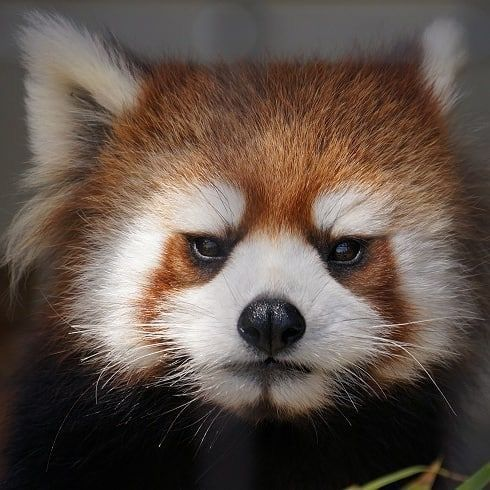

In [ ]:
from IPython.display import Image, display

display(Image(filename='example.jpg'))

In [ ]:
from PIL import Image as Img

im = Img.open('example.jpg')

print(im.size)
type(im)

(490, 490)


PIL.JpegImagePlugin.JpegImageFile

In [ ]:
from torchvision import transforms

In [ ]:
trans = transforms.ToTensor()

x = trans(im)

In [ ]:
print(x.size())

torch.Size([3, 490, 490])


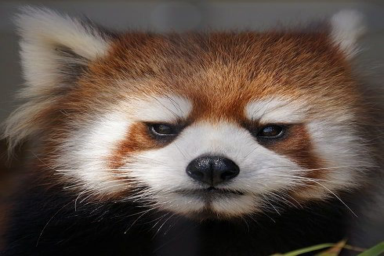

(384, 256)


In [ ]:
trans = transforms.Resize((256, 384))

resized = trans(im)

display(resized)
print(resized.size)

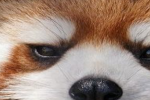

In [ ]:
trans = transforms.CenterCrop((100, 150))

newim = trans(resized)

display(newim)

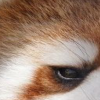

In [ ]:
trans = transforms.RandomCrop((100, 100), padding=30, padding_mode='constant')

newim = trans(resized)

display(newim)

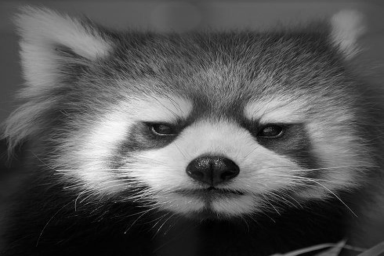

In [ ]:
trans = transforms.Grayscale()

newim = trans(resized)

display(newim)

In [ ]:
trans = transforms.ToTensor()

print(trans(newim).size())

torch.Size([1, 256, 384])


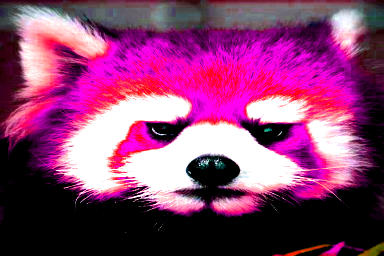

In [ ]:
trans = transforms.ColorJitter(brightness=0, contrast=3, saturation=6, hue=0.3)

newim = trans(resized)

display(newim)

In [ ]:
trans = transforms.RandomVerticalFlip(p=1)

newim = trans(resized)

display(newim)

In [ ]:
trans = transforms.RandomRotation(degrees=40, center=(40, 70))

newim = trans(resized)

display(newim)

In [ ]:
trans = transforms.RandomAffine(degrees=0, translate=(0.2, 0.8))

newim = trans(resized)

display(newim)

In [ ]:
trans = transforms.Resize((4, 6))

resized = trans(im)

trans = transforms.ToTensor()

x = trans(resized)

print(x[:2, :2])

In [ ]:
trans = transforms.Normalize(mean=(0.5, 0.3, 0.2), std=(0.5, 0.4, 0.5))

newx = trans(x)

print(newx[:2, :2])

In [ ]:
trans = transforms.RandomErasing(p=1, scale=(0.1, 0.3))

newx = trans(x)

print(newx[:2, :2])

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(),
    transforms.RandomAffine(degrees=20, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5)),
])

## torchvision.datasets

In [ ]:
import torchvision.datasets as datasets

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

train_dataset = datasets.MNIST(
    root='./',
    download=True,
    train=True,
    transform=transform
)

test_dataset = datasets.MNIST(
    root='./',
    download=False,
    train=False,
    transform= transform
)